In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [4]:
df['IsPayment'] = df['type'].apply(lambda x: 1 if x == 'PAYMENT' or x == 'DEBIT' else 0)
df['IsMovement'] = df['type'].apply(lambda x: 1 if x == 'TRANSFER' or x == 'CASH_OUT' else 0)

In [5]:
df['accountDiff'] = abs(df['oldbalanceDest'] - df['oldbalanceOrg'])
df.accountDiff.describe()

count    6.362620e+06
mean     1.563497e+06
std      4.027698e+06
min      0.000000e+00
25%      2.016600e+04
50%      2.145337e+05
75%      1.311500e+06
max      3.560159e+08
Name: accountDiff, dtype: float64

In [6]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<!-- ## Undersampling -->
## Oversampling

In [7]:
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# under_sampler = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

In [8]:
features = df[['amount', 'IsPayment', 'IsMovement', 'accountDiff']]
target = df['isFraud']

In [9]:
"""
Undersample the majority class of the dataset using RandomUnderSampler from imblearn library.
This is done to balance the dataset and avoid the model to be biased towards the majority class.
The undersampled dataset is saved in X_over and y_over variables.
"""

# features_over, target_over = under_sampler.fit_resample(features, target)
features_over, target_over = smote.fit_resample(features, target)
features_over.shape, target_over.shape

((12708814, 4), (12708814,))

## Splitting and normalizing data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features_over, target_over, test_size=0.25, random_state=43)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9531610, 4), (9531610,), (3177204, 4), (3177204,))

In [11]:
z_scaler = StandardScaler()
x_train = z_scaler.fit_transform(x_train)
x_test = z_scaler.transform(x_test)

## Training the model

In [12]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [13]:
model.score(x_train, y_train)

0.7974364246963525

In [14]:
model.score(x_test, y_test)

0.7981416994313238

In [15]:
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75   1587739
           1       0.72      0.98      0.83   1589465

    accuracy                           0.80   3177204
   macro avg       0.84      0.80      0.79   3177204
weighted avg       0.84      0.80      0.79   3177204



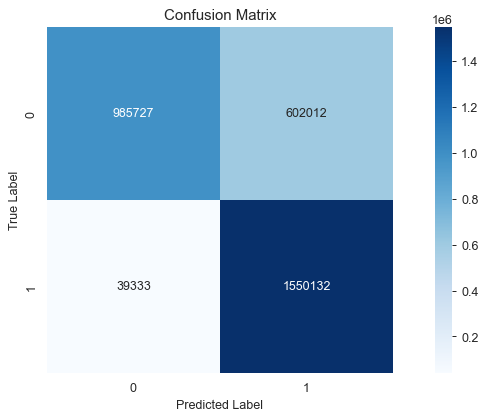

In [16]:
plt.figure(figsize=(12, 5), dpi=90)

sns.heatmap(
    confusion_matrix(y_test, model.predict(x_test)),
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
model.coef_

array([[ 2.21788755, -0.55052831,  6.03365354, -0.83234207]])

In [18]:
transaction1 = np.array([123456.78, 0.0, 1.0, 54670.1])
transaction2 = np.array([98765.43, 1.0, 0.0, 8524.75])
transaction3 = np.array([543678.31, 1.0, 0.0, 510025.5])
transaction4 = np.array([6472.54, 1.0, 0.0, 55901.23])

sample_transactions = np.stack((transaction1,transaction2,transaction3,transaction3))
sample_transactions

array([[1.2345678e+05, 0.0000000e+00, 1.0000000e+00, 5.4670100e+04],
       [9.8765430e+04, 1.0000000e+00, 0.0000000e+00, 8.5247500e+03],
       [5.4367831e+05, 1.0000000e+00, 0.0000000e+00, 5.1002550e+05],
       [5.4367831e+05, 1.0000000e+00, 0.0000000e+00, 5.1002550e+05]])

In [19]:
sample_transactions = z_scaler.transform(sample_transactions)
model.predict(sample_transactions)

array([1, 0, 0, 0], dtype=int64)

In [20]:
model.predict_proba(sample_transactions)

array([[3.68345375e-01, 6.31654625e-01],
       [9.99999407e-01, 5.92521911e-07],
       [9.99999091e-01, 9.08508354e-07],
       [9.99999091e-01, 9.08508354e-07]])

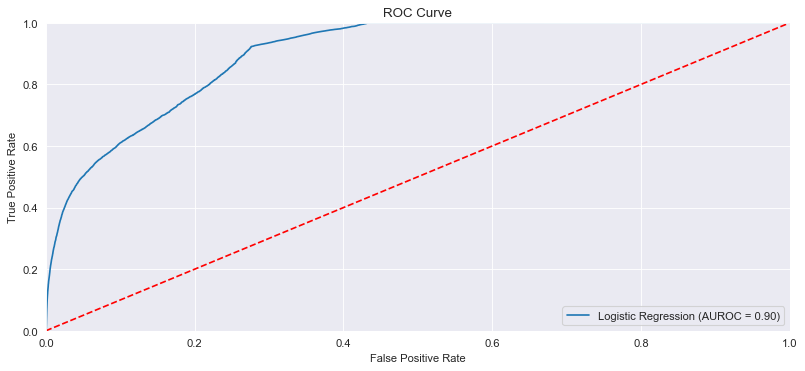

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

plt.figure(figsize=(12, 5))

plt.plot(fpr, tpr, label='Logistic Regression (AUROC = %0.2f)' % roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()